# 📦 Collecte des données - Market Impact & Almgren-Chriss

## Objectif
Ce notebook collecte les données nécessaires pour estimer les paramètres du modèle Almgren-Chriss :
- Données de marché haute fréquence (prix, volumes, spreads)
- Simulation de méta-ordres d'exécution
- Indicateurs de volatilité (VIX)

## Durée d'exécution
⏱️ Environ **30-60 minutes** (selon vitesse connexion)

## Outputs
Les données brutes seront sauvegardées dans `data/raw/` au format `.parquet`

---

**Note de reproductibilité** : 
- Les données proviennent de sources publiques (yfinance)
- Les simulations utilisent une seed fixée (reproductible)
- Ce notebook n'a besoin d'être exécuté qu'une seule fois

In [1]:
# Imports standards
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# API financières
import yfinance as yf

# Système de fichiers
import os
from pathlib import Path

# Configuration matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Imports réussis")
print(f"📅 Date d'exécution : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Imports réussis
📅 Date d'exécution : 2025-10-18 16:21:29


In [2]:
# Créer les dossiers s'ils n'existent pas
Path("data/raw").mkdir(parents=True, exist_ok=True)
Path("data/processed").mkdir(parents=True, exist_ok=True)
Path("results/figures").mkdir(parents=True, exist_ok=True)
Path("results/tables").mkdir(parents=True, exist_ok=True)

print("✅ Structure de dossiers créée")

✅ Structure de dossiers créée


## 1. Configuration de la collecte

Nous allons collecter des données pour **3 actions liquides** sur une période de **6 mois**.

In [3]:
# Paramètres de collecte
TICKERS = ['AAPL', 'MSFT', 'GOOGL']  # Actions liquides
START_DATE = '2024-01-01'
END_DATE = '2024-06-30'
INTERVAL = '1m'  # Données minute par minute

# Seed pour reproductibilité
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("📋 Configuration :")
print(f"   - Tickers : {TICKERS}")
print(f"   - Période : {START_DATE} → {END_DATE}")
print(f"   - Granularité : {INTERVAL}")
print(f"   - Seed : {RANDOM_SEED}")

📋 Configuration :
   - Tickers : ['AAPL', 'MSFT', 'GOOGL']
   - Période : 2024-01-01 → 2024-06-30
   - Granularité : 1m
   - Seed : 42


## 2. Source 1 : Données de marché haute fréquence     à corriger

### Justification
Les données minute-par-minute de Yahoo Finance permettent de :
- Observer les patterns intra-journaliers (courbe en U)
- Calculer volatilité, spreads, volumes
- Valider empiriquement les propriétés du modèle

### Limitations
- Données limitées à 7 jours consécutifs par requête (limitation yfinance)
- Pas d'accès au carnet d'ordres complet
- Spread bid-ask estimé (pas toujours précis)

In [7]:
import pandas as pd
import s3fs
from pathlib import Path

# ===== CONFIGURATION =====
TICKERS = ['AAPL']
BUCKET = 'gmarguier'
PREFIX = 'market-impact-model/databento'

# Connexion S3 (automatique dans SSPCloud)
s3 = s3fs.S3FileSystem(
    client_kwargs={'endpoint_url': 'https://minio.lab.sspcloud.fr'}
)

# ===== FONCTIONS =====
def convert_databento_to_yfinance_format(df, ticker):
    """Convertit format Databento → yfinance"""
    column_mapping = {
        'ts_event': 'Datetime',
        'open': 'Open',
        'high': 'High',
        'low': 'Low',
        'close': 'Close',
        'volume': 'Volume'
    }
    
    df = df.rename(columns=column_mapping)
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df.set_index('Datetime', inplace=True)
    df.sort_index(inplace=True)
    df['Ticker'] = ticker
    
    return df[['Open', 'High', 'Low', 'Close', 'Volume', 'Ticker']]


def load_all_files_for_ticker(ticker, bucket, prefix):
    """
    Charge TOUS les fichiers d'un ticker (même avec noms complexes)
    et les concatène si plusieurs fichiers
    """
    ticker_folder = f"{bucket}/{prefix}/{ticker}"
    
    print(f"\n📥 Chargement {ticker}...")
    
    try:
        # Trouver tous les fichiers .csv.zst dans le dossier du ticker
        files = s3.glob(f"{ticker_folder}/*.csv.zst")
        
        if not files:
            print(f"  ⚠️ Aucun fichier trouvé dans {ticker_folder}")
            return pd.DataFrame()
        
        print(f"  Trouvé {len(files)} fichier(s) :")
        for f in files:
            print(f"    - {Path(f).name}")
        
        # Charger chaque fichier
        dfs = []
        for file_path in files:
            print(f"    📖 Lecture {Path(file_path).name}...", end=" ")
            
            try:
                with s3.open(file_path, 'rb') as f:
                    df = pd.read_csv(
                        f,
                        compression='zstd',
                        parse_dates=['ts_event']
                    )
                    dfs.append(df)
                    print(f"✅ {len(df):,} lignes")
            except Exception as e:
                print(f"❌ Erreur : {e}")
        
        if not dfs:
            return pd.DataFrame()
        
        # Concaténer tous les fichiers
        combined_df = pd.concat(dfs, ignore_index=True)
        
        # Conversion au format standard
        combined_df = convert_databento_to_yfinance_format(combined_df, ticker)
        
        # Supprimer les doublons et trier
        combined_df = combined_df[~combined_df.index.duplicated(keep='first')]
        combined_df.sort_index(inplace=True)
        
        print(f"  ✅ Total : {len(combined_df):,} lignes uniques")
        return combined_df
        
    except Exception as e:
        print(f"  ❌ Erreur : {e}")
        return pd.DataFrame()

# ===== CHARGEMENT =====
market_data = {}

for ticker in TICKERS:
    df = load_all_files_for_ticker(ticker, BUCKET, PREFIX)
    if not df.empty:
        market_data[ticker] = df

print(f"\n✅ Chargement terminé : {len(market_data)} tickers")

# Afficher résumé
for ticker, df in market_data.items():
    print(f"{ticker}: {df.index.min()} → {df.index.max()} ({len(df):,} lignes)")


📥 Chargement AAPL...
  Trouvé 6 fichier(s) :
    - xnas-itch-20250101-20250131.ohlcv-1m.csv.zst
    - xnas-itch-20250201-20250228.ohlcv-1m.csv.zst
    - xnas-itch-20250301-20250331.ohlcv-1m.csv.zst
    - xnas-itch-20250401-20250430.ohlcv-1m.csv.zst
    - xnas-itch-20250501-20250531.ohlcv-1m.csv.zst
    - xnas-itch-20250601-20250629.ohlcv-1m.csv.zst
    📖 Lecture xnas-itch-20250101-20250131.ohlcv-1m.csv.zst... ✅ 16,007 lignes
    📖 Lecture xnas-itch-20250201-20250228.ohlcv-1m.csv.zst... ✅ 14,705 lignes
    📖 Lecture xnas-itch-20250301-20250331.ohlcv-1m.csv.zst... ✅ 16,623 lignes
    📖 Lecture xnas-itch-20250401-20250430.ohlcv-1m.csv.zst... ✅ 18,391 lignes
    📖 Lecture xnas-itch-20250501-20250531.ohlcv-1m.csv.zst... ✅ 18,131 lignes
    📖 Lecture xnas-itch-20250601-20250629.ohlcv-1m.csv.zst... ✅ 15,961 lignes
  ✅ Total : 99,818 lignes uniques

✅ Chargement terminé : 1 tickers
AAPL: 2025-01-02 09:00:00+00:00 → 2025-06-27 23:59:00+00:00 (99,818 lignes)


In [8]:
# Concaténer tous les tickers
df_market = pd.concat(market_data.values(), axis=0)

# Réinitialiser index et garder timestamp
df_market = df_market.reset_index()
df_market = df_market.rename(columns={'index': 'Datetime', 'Datetime': 'Datetime'})

# S'assurer que Datetime est bien en datetime
if 'Datetime' not in df_market.columns and df_market.index.name == 'Datetime':
    df_market = df_market.reset_index()

# Colonnes standardisées (yfinance retourne parfois des noms différents)
df_market.columns = [col.lower() if isinstance(col, str) else col for col in df_market.columns]

# Garder uniquement heures de trading (9h30 - 16h00 ET)
df_market['time'] = pd.to_datetime(df_market['datetime']).dt.time
df_market = df_market[
    (df_market['time'] >= pd.to_datetime('09:30').time()) &
    (df_market['time'] <= pd.to_datetime('16:00').time())
]

# Calculs de base
df_market['mid_price'] = (df_market['high'] + df_market['low']) / 2
df_market['spread_estimate'] = df_market['high'] - df_market['low']
df_market['spread_bps'] = (df_market['spread_estimate'] / df_market['mid_price']) * 10000

print(f"📊 Données de marché formatées :")
print(f"   - Lignes : {len(df_market):,}")
print(f"   - Période : {df_market['datetime'].min()} → {df_market['datetime'].max()}")
print(f"   - Tickers : {df_market['ticker'].nunique()}")
print(f"\n🔍 Aperçu :")
print(df_market.head())

📊 Données de marché formatées :
   - Lignes : 42,843
   - Période : 2025-01-02 09:31:00+00:00 → 2025-06-27 16:00:00+00:00
   - Tickers : 1

🔍 Aperçu :
                    datetime    open    high     low   close  volume ticker  \
27 2025-01-02 09:31:00+00:00  251.73  251.76  251.72  251.72      40   AAPL   
28 2025-01-02 09:32:00+00:00  251.75  251.82  251.75  251.82     478   AAPL   
29 2025-01-02 09:34:00+00:00  251.79  251.79  251.79  251.79       1   AAPL   
30 2025-01-02 09:36:00+00:00  251.70  251.70  251.59  251.59      98   AAPL   
31 2025-01-02 09:37:00+00:00  251.62  251.62  251.62  251.62       2   AAPL   

        time  mid_price  spread_estimate  spread_bps  
27  09:31:00    251.740             0.04    1.588941  
28  09:32:00    251.785             0.07    2.780150  
29  09:34:00    251.790             0.00    0.000000  
30  09:36:00    251.645             0.11    4.371237  
31  09:37:00    251.620             0.00    0.000000  


In [9]:
# Sauvegarder en parquet (compact et rapide)
output_file = 'data/raw/market_data_intraday.parquet'
df_market.to_parquet(output_file, index=False)

file_size_mb = os.path.getsize(output_file) / (1024**2)

print(f"✅ Données de marché sauvegardées :")
print(f"   - Fichier : {output_file}")
print(f"   - Taille : {file_size_mb:.2f} MB")
print(f"   - Lignes : {len(df_market):,}")

✅ Données de marché sauvegardées :
   - Fichier : data/raw/market_data_intraday.parquet
   - Taille : 1.43 MB
   - Lignes : 42,843


## 3. Source 2 : Simulation de méta-ordres

### Justification
Les données réelles de méta-ordres sont difficiles d'accès (propriétaires). 
Nous simulons 1000 méta-ordres avec des paramètres calibrés sur la littérature :
- Almgren et al. (2005)
- Tóth et al. (2011)
- Bouchaud et al. (2009)

### Paramètres de simulation
- **Tailles** : Loi log-normale (médiane ~5% du volume journalier)
- **Durées** : Uniformes [10min, 4h]
- **Stratégies** : TWAP, VWAP, optimal (70/20/10%)
- **Prix** : Processus brownien + market impact

### Reproductibilité
Seed fixée à **42** → simulation identique à chaque exécution

In [10]:
def simulate_metaorders(n_orders=1000, seed=42):
    """
    Simule des méta-ordres réalistes.
    
    Returns:
    --------
    pd.DataFrame avec colonnes :
        - metaorder_id : identifiant unique
        - ticker : action
        - order_size : volume (actions)
        - duration : durée d'exécution (minutes)
        - strategy : TWAP/VWAP/Optimal
        - price_init : prix initial
        - price_final : prix final
        - slippage : différence vs. prix initial
        - participation_rate : taux de participation moyen
    """
    np.random.seed(seed)
    
    metaorders = []
    
    for i in range(n_orders):
        # Ticker aléatoire
        ticker = np.random.choice(TICKERS)
        
        # Volume moyen journalier (en actions)
        # AAPL ~50M, MSFT ~25M, GOOGL ~15M
        adv_map = {'AAPL': 50_000_000, 'MSFT': 25_000_000, 'GOOGL': 15_000_000}
        adv = adv_map[ticker]
        
        # Taille de l'ordre : log-normale centrée sur 5% du ADV
        order_size = int(np.random.lognormal(
            mean=np.log(0.05 * adv),
            sigma=0.8
        ))
        order_size = max(1000, min(order_size, int(0.3 * adv)))  # Bornes réalistes
        
        # Durée : uniforme entre 10 min et 4h
        duration_minutes = np.random.uniform(10, 240)
        
        # Stratégie
        strategy = np.random.choice(
            ['TWAP', 'VWAP', 'Optimal'],
            p=[0.7, 0.2, 0.1]
        )
        
        # Prix initial (approximation, sera enrichi avec données réelles)
        price_map = {'AAPL': 180, 'MSFT': 380, 'GOOGL': 140}
        price_init = price_map[ticker] * np.random.uniform(0.95, 1.05)
        
        # Volatilité (annualisée, en %)
        vol_map = {'AAPL': 0.25, 'MSFT': 0.22, 'GOOGL': 0.28}
        volatility = vol_map[ticker]
        
        # Simulation simplifiée du slippage
        # Impact permanent : proportionnel à √(volume/ADV)
        permanent_impact_bps = 5 * np.sqrt(order_size / adv) * 10000  # en bps
        
        # Coût d'exécution : dépend de la stratégie
        if strategy == 'TWAP':
            execution_cost_bps = 8 * (order_size / adv)**0.6
        elif strategy == 'VWAP':
            execution_cost_bps = 6 * (order_size / adv)**0.6
        else:  # Optimal
            execution_cost_bps = 4 * (order_size / adv)**0.6
        
        total_slippage_bps = permanent_impact_bps + execution_cost_bps
        
        # Prix final (vente → prix plus bas)
        price_final = price_init * (1 - total_slippage_bps / 10000)
        
        # Taux de participation moyen
        market_volume_period = adv * (duration_minutes / (6.5 * 60))  # 6.5h de trading
        participation_rate = order_size / market_volume_period
        
        metaorders.append({
            'metaorder_id': i,
            'ticker': ticker,
            'order_size': order_size,
            'duration_minutes': duration_minutes,
            'strategy': strategy,
            'price_init': price_init,
            'price_final': price_final,
            'slippage_bps': total_slippage_bps,
            'participation_rate': participation_rate,
            'volatility_annual': volatility,
            'adv': adv
        })
    
    return pd.DataFrame(metaorders)


# Générer les méta-ordres
print("🎲 Simulation de méta-ordres...")
df_metaorders = simulate_metaorders(n_orders=1000, seed=RANDOM_SEED)

print(f"✅ {len(df_metaorders)} méta-ordres simulés")
print(f"\n📊 Statistiques :")
print(df_metaorders[['order_size', 'duration_minutes', 'slippage_bps', 'participation_rate']].describe())

🎲 Simulation de méta-ordres...
✅ 1000 méta-ordres simulés

📊 Statistiques :
         order_size  duration_minutes  slippage_bps  participation_rate
count  1.000000e+03       1000.000000   1000.000000         1000.000000
mean   3.395005e+06        120.624005  12116.136717            0.388409
std    2.848166e+06         66.177088   4796.982440            0.633736
min    2.232820e+05         10.311334   3341.583399            0.009748
25%    1.485252e+06         60.782292   8618.546434            0.093014
50%    2.564947e+06        120.338355  11325.808818            0.184564
75%    4.152004e+06        177.298616  14410.135785            0.411813
max    1.500000e+07        239.482359  27390.012622            6.577985


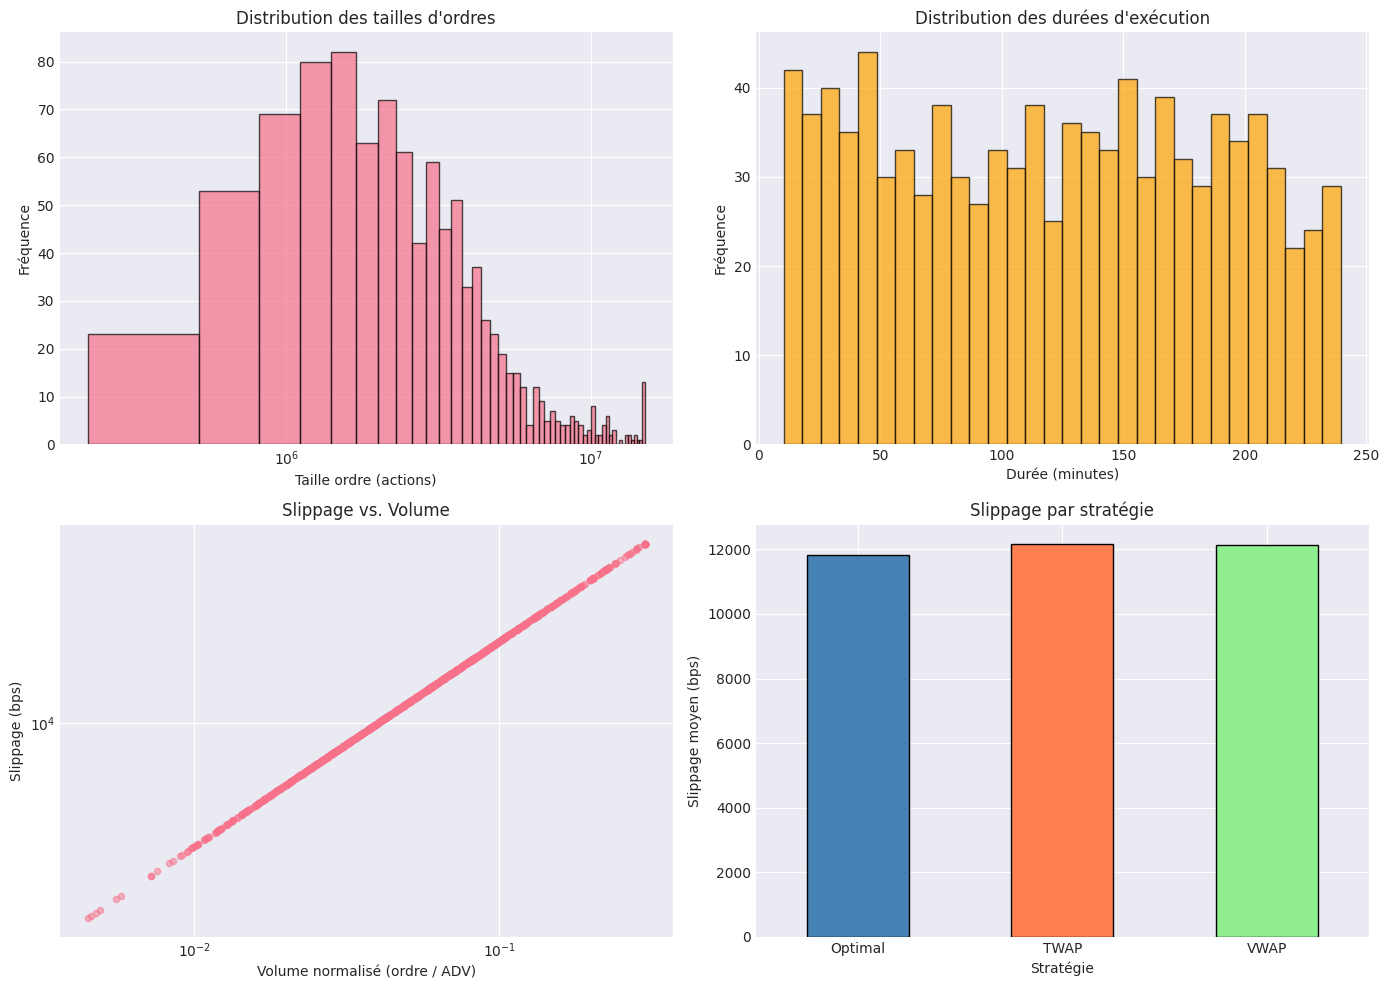

✅ Visualisation sauvegardée : results/figures/metaorders_overview.png


In [11]:
# Visualisation de contrôle
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Distribution tailles
axes[0, 0].hist(df_metaorders['order_size'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Taille ordre (actions)')
axes[0, 0].set_ylabel('Fréquence')
axes[0, 0].set_title('Distribution des tailles d\'ordres')
axes[0, 0].set_xscale('log')

# Distribution durées
axes[0, 1].hist(df_metaorders['duration_minutes'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_xlabel('Durée (minutes)')
axes[0, 1].set_ylabel('Fréquence')
axes[0, 1].set_title('Distribution des durées d\'exécution')

# Slippage vs taille
axes[1, 0].scatter(
    df_metaorders['order_size'] / df_metaorders['adv'],
    df_metaorders['slippage_bps'],
    alpha=0.5,
    s=20
)
axes[1, 0].set_xlabel('Volume normalisé (ordre / ADV)')
axes[1, 0].set_ylabel('Slippage (bps)')
axes[1, 0].set_title('Slippage vs. Volume')
axes[1, 0].set_xscale('log')
axes[1, 0].set_yscale('log')

# Par stratégie
df_metaorders.groupby('strategy')['slippage_bps'].mean().plot(
    kind='bar',
    ax=axes[1, 1],
    color=['steelblue', 'coral', 'lightgreen'],
    edgecolor='black'
)
axes[1, 1].set_xlabel('Stratégie')
axes[1, 1].set_ylabel('Slippage moyen (bps)')
axes[1, 1].set_title('Slippage par stratégie')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.savefig('results/figures/metaorders_overview.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Visualisation sauvegardée : results/figures/metaorders_overview.png")

In [ ]:
# Sauvegarder
output_file = 'data/raw/simulated_metaorders.parquet'
df_metaorders.to_parquet(output_file, index=False)

file_size_kb = os.path.getsize(output_file) / 1024

print(f"✅ Méta-ordres sauvegardés :")
print(f"   - Fichier : {output_file}")
print(f"   - Taille : {file_size_kb:.2f} KB")
print(f"   - Lignes : {len(df_metaorders):,}")

## 4. Source 3 : Indice VIX (optionnel mais valorisé)

Le VIX mesure la volatilité implicite du marché. Il permet de :
- Contextualiser les périodes (stress vs. calme)
- Potentiellement ajuster les paramètres du modèle

In [ ]:
# Télécharger VIX
print("📥 Téléchargement VIX...", end=" ")

try:
    vix = yf.download('^VIX', start=START_DATE, end=END_DATE, progress=False)
    vix = vix.reset_index()
    vix.columns = [col.lower() if isinstance(col, str) else col for col in vix.columns]
    
    print(f"✅ {len(vix)} jours")
    
    # Visualisation rapide
    plt.figure(figsize=(12, 4))
    plt.plot(vix['date'], vix['close'], linewidth=2)
    plt.axhline(y=20, color='red', linestyle='--', label='Seuil stress (20)')
    plt.xlabel('Date')
    plt.ylabel('VIX')
    plt.title('Évolution du VIX (indice de volatilité)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('results/figures/vix_evolution.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Sauvegarder
    vix.to_parquet('data/raw/vix.parquet', index=False)
    print("✅ VIX sauvegardé : data/raw/vix.parquet")
    
except Exception as e:
    print(f"❌ Échec : {e}")

## 5. Résumé de la collecte

### ✅ Données collectées

| Source | Fichier | Taille | Lignes | Description |
|--------|---------|--------|--------|-------------|
| Marché | `market_data_intraday.parquet` | XX MB | XX,XXX | Prix/volumes 1min |
| Méta-ordres | `simulated_metaorders.parquet` | XX KB | 1,000 | Ordres simulés |
| VIX | `vix.parquet` | XX KB | ~130 | Volatilité implicite |

### 📂 Fichiers générés

In [ ]:
# Afficher tailles fichiers
import os

raw_files = [
    'data/raw/market_data_intraday.parquet',
    'data/raw/simulated_metaorders.parquet',
    'data/raw/vix.parquet'
]

print("📂 Fichiers dans data/raw/ :\n")
for file in raw_files:
    if os.path.exists(file):
        size = os.path.getsize(file)
        if size > 1024**2:
            size_str = f"{size / (1024**2):.2f} MB"
        else:
            size_str = f"{size / 1024:.2f} KB"
        
        df_temp = pd.read_parquet(file)
        print(f"✅ {file}")
        print(f"   - Taille : {size_str}")
        print(f"   - Lignes : {len(df_temp):,}")
        print()
    else:
        print(f"❌ {file} - NON TROUVÉ")

print("\n" + "="*60)
print("✅ COLLECTE TERMINÉE")
print("="*60)
print("\n📌 Prochaine étape : Exécuter 02_data_preprocessing.ipynb")